## A Hacker's Guide to Having Your NYTimes Article Comments Noticed

<p align="center">
Gavril Bilev
allattention at gmail.com
June 14, 2018
</p>

### The problem: predicting the number of upvotes ('recommendations') that a comment posted to an article on the [New York Times](www.nytimes.com) will receive. 

![Imgur](https://i.imgur.com/Vm9tAsj.png?1)


### **TL&DR**
If you want upvotes:
* **Time is of the essence, the sooner you comment, the better!**
* **Commenting on comments doesn't bring in the upvotes**
* **There is an optimal article length for getting upvoted comments - at about 800 words.**
* **Print page - most of the important big-headline articles appear in the first 30 pages of the paper, where they attract more readers and more comments.**
* **Getting the coveted 'NYTimes Pick' helps a lot. So does being a trusted user or a NYTimes reporter.**
* **Hot button issues bring about reactions, but not always upvotes** 
* **Effort pays off:**
    * say more
    * use a rich vocabulary 
    * refer to people, places and organizations, but sparingly 
    * spell-check
* **Don't be too negative or too positive, be slightly positive.**





Readers of the [Gray Lady](www.nytimes.com) are able to post comments on articles and react to the comments of others by either upvoting ('Recommend' button) or replying. For a comment-author, recommendations are desirable because they bring about more visibility - recommended comments float up to the top where they are seen by more readers and can receive even more upvotes. Once a comment 'snowballs' it can be seen by potentially millions of readers. Presumably we write comments because we want others to see them.

I got curious about what makes some comments rise to the top while most others are completely ignored. [Aashita Kesarwani](https://www.kaggle.com/aashita https://www.kaggle.com/aashita) posted a cool dataset on [Kaggle](www.kaggle.com) of more than 2 million comments geared toward addressing this and similar questions. Be sure to check out the dataset [here](https://www.kaggle.com/aashita/nyt-comments) as well as her wonderful exploratory data analysis of it [here](https://www.kaggle.com/aashita/exploratory-data-analysis-of-comments-on-nyt/data). The data come from two time periods: Jan-May 2017 and Jan-April 2018 and contain features on both the comments (with the full raw text body of each comment) and the more than 9 thousand NYTimes articles the comments were responding to.

I like this as a prediction task because it is challenging. Presumably what makes people upvote comments or posts, not just at the Times but also in other social media settings (Reddit, Twitter, FB, etc) is the _meaning_ of the comment - they find it helpful, or funny or simply agree with it and want others to see it too. Since we can't easily quantify 'meaning,' we'll have to rely on some feature engineering in order to get any traction with our predictions. The task is also challenging because we don't know much about the readers who are responding to comments and do not have the full text of the articles. Additionally, some comments are pretty short, so they are not easily amenable to a more complicated language model. After extracting what we can from the features already present in the dataset, we will have to wrangle useful information out of noisy and messy raw text - the body of the comments.

The main point to consider here is that we need to set our expectations low, because this is no handwritten digit recognition exercise with 99%+ accuracy. Even a human scorer would probably not do well in terms of predicting upvotes. Consider these two comments, both made in response to the same article:

> A. '_Everyone should have walked out.  Spicer could have talked to himself._'

> B. '_If people are "alarmed" and "appalled" that Trump did this, followed by his cronies justification of it, then they haven't been paying attention. I'm just surprised he took this long to do it. The story here, the one that people should actually be alarmed and appalled by is that the rest of the press stayed. Brietbart, One America, not so surprising but there is absolutely no excuse for rest to have shown so little respect for the one of the most important and defining features of America... The First Amendment, a free press. To echo Mr Kahn's question to President Trump...have you even read the constitution? Here, let me give you a head start... Amendment I: Congress shall make no law respecting an establishment of religion, or prohibiting the free exercise thereof; or abridging the freedom of speech, or of the press; or the right of the people peaceably to assemble, and to petition the Government for a redress of grievances._'

Without any contextual knowledge, I would have guessed that the two comments would be roughly on par or the first one would receive fewer upvotes. They are generally similar in terms of the reaction to the article, though the second comment is longer and contains more information. The reality is quite different: comment A received over 10,000 upvotes and is the most upvoted comment in the entire dataset, while comment B got ... zero upvotes. 

If you are interested in the takeaways (and one very plausible explanation about the popularity of these two comments, it is not simply brevity!), skip right to the last section. In the sections that follow we will go through the traditional steps of classification, with an emphasis on feature engineering out of the numerical and text data.

The original target variable here is a count variable of recommendations. For the artificial purpose of using classification algos and metrics, I will discretize it to four meaningful and roughly equal-sized categories. Since the largest of them is about 29%, this is our prediction baseline: if we simply picked that always, our classification would be accurate 29% of the time.

Categories:
1. None ~29%
2. One or two ~29%
3. Three to eight ~23%
4. More than eight (up to tens of thousands) ~18%

Naturally, you also choose to keep the original target variable (though cropping the right tail of the distribution might be a good idea due to how skewed it is) and rely on regression and metrics such as mean squared error. (In that case, it would probably be most appropriate to use a negative binomial model for the first simple fit, due to the count nature of the data and the fact that zero has meaning.)


### Table of contents:
1. [Data Loading & Preparation](#data)
    1. [Load data files & combine](#dataloading)
	2. [Discretize **recommendations** (target)](#cut)
	3. [Turn categorical to dummies](#todummies)
2. [Initial prediction](#initpredict)
	1. [Simple Multinomial Logistic](#logit)
	2. [A bag of classifiers](#classifiers)
3. [Feature Engineering](#featureengineering)
    1. [Features based on original variables](#originalvars)
        1. [Replyupvotes](#reply)
        2. [byline](#byline)
        3. [Time](#time)
    2. [Features based on raw text data](#textdata)
        1. [A NYTimes vocabulary & IDF profile](#vocab)
		2. [Basic stats, sentiment analysis, spelling errors & part of speech](#kitchensink)
		3. [Text token features](#texttokens)
4. [Training & Re-evaluation](#training)
	1. [Simple Multinomial Logistic](#finallogit)
	2. [A bag of classifiers](#finalclassifiers)
5. [Takeaways](#tldr)


Data loading <a name='dataloading'></a>

First, let's prepare the data. We'll load almost all features present in the .csv files in their original shapes into a large dataframe, drop features that cannot be useful (too many missing cases) and convert the categorical features to dummies. This will enable us to do a first-cut prediction without  feature engineering - almost as if we know nothing about the dataset and are doing a blind prediction. 'Almost' because we will deliberately exclude one feature that is surely related to the target - the number of replies a comment has received (**replyCount**). We would expect this to be an effect (consequence), rather than a cause of the number of upvotes - upvoted comments are highly visible and therefore much more likely to receive replies.

We will initially ignore the raw text features (body of comments and keywords of the article) but keep them for later. Finally, to speed up our work here, we will take a random sample of about 10% of the cases (sometimes called 'dev set'). 

Load libraries and already-downloaded data first. There are two separate sets of files, the first containing comments and comment-features and the second containing features about the articles. We read in all of the data, merge them into one Pandas Dataframe where each row is a comment and eliminate all duplicates. 
                              


In [1]:
import glob
import pandas as pd
import numpy as np
import calendar
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# set a few options:
sns.set(style='whitegrid')
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100
%matplotlib inline
# Kernel to predict upvotes ('recommendations' as target); will cut into intervals to turn this into a classification exercise


1. Load data files & combine <a name='dataloading'></a>

In [2]:
# small function to read all .csv files containing a string
def read_files(string='Articles', path='./Data/'):
    '''Read zipped .csv files starting with string and concat them into a pd.DataFrame'''
    files = glob.glob(path + string + '*.csv.zip')
    list_dfs = []
    for csv in files:
        df_ = pd.read_csv(csv)
        list_dfs.append(df_)
    return pd.concat(list_dfs)


# read in the articles files
df_articles = read_files('Articles')

# brief look inside:
print(df_articles.info())

# Leave only features which are not already present in the comments data, do not have too many missing values and could potentially be useful (poked around a bit)
useful_columns = ['articleID',
                  'byline',
                  'headline',
                  'keywords',
                  'pubDate',
                  'snippet',
                  'documentType'
                  ]

df_articles = df_articles[useful_columns]
print(df_articles.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9335 entries, 0 to 1323
Data columns (total 16 columns):
abstract            167 non-null object
articleID           9335 non-null object
articleWordCount    9335 non-null int64
byline              9335 non-null object
documentType        9335 non-null object
headline            9335 non-null object
keywords            9335 non-null object
multimedia          9335 non-null int64
newDesk             9335 non-null object
printPage           9335 non-null int64
pubDate             9335 non-null object
sectionName         9335 non-null object
snippet             9335 non-null object
source              9335 non-null object
typeOfMaterial      9335 non-null object
webURL              9335 non-null object
dtypes: int64(3), object(13)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9335 entries, 0 to 1323
Data columns (total 7 columns):
articleID       9335 non-null object
byline          9335 non-null object
headl

Do the same for the comments files, merge the two into one DataFrame and drop all duplicates:


In [3]:
# read in the Comments files (large-ish, 500M+)
df_comments = read_files('Comments')
print(df_comments.info())
# join the two by articleID; drop the comments that are not associated with articles
df = pd.merge(df_comments, df_articles, how='inner',
              on='articleID')
# drop duplicate comments
df.drop_duplicates(subset='commentID', inplace=True)
print(df.shape)
df.reset_index(drop=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176364 entries, 0 to 233406
Data columns (total 34 columns):
approveDate              int64
articleID                object
articleWordCount         float64
commentBody              object
commentID                float64
commentSequence          float64
commentTitle             object
commentType              object
createDate               float64
depth                    float64
editorsSelection         int64
inReplyTo                float64
newDesk                  object
parentID                 float64
parentUserDisplayName    object
permID                   object
picURL                   object
printPage                float64
recommendations          float64
recommendedFlag          float64
replyCount               float64
reportAbuseFlag          float64
sectionName              object
sharing                  int64
status                   object
timespeople              float64
trusted                  float64
typeOfMateria

Count missing values and drop the features if there are too many (> 1 million) missing. We can come back later and try to extract useful information from them.

In [4]:
print(df.isnull().sum())

# several features are missing for most or all cases, drop them
df = df.loc[:, df.isnull().sum() < 10**6]
print(df.shape)

approveDate                    0
articleID                      0
articleWordCount               0
commentBody                    0
commentID                      0
commentSequence                0
commentTitle               73979
commentType                    0
createDate                     0
depth                          0
editorsSelection               0
inReplyTo                      0
newDesk                        0
parentID                       0
parentUserDisplayName    1528830
permID                        22
picURL                         0
printPage                      0
recommendations                0
recommendedFlag          2086862
replyCount                     0
reportAbuseFlag          2086862
sectionName               149613
sharing                        0
status                         0
timespeople                    0
trusted                        0
typeOfMaterial                 0
updateDate                     0
userDisplayName              641
userID    

Discretizing the target variable <a name='cut'></a>

Next, look at the target (**Recommendations**) and turn it into four categories for classification. The original variable is a count heavily slanted toward zero:

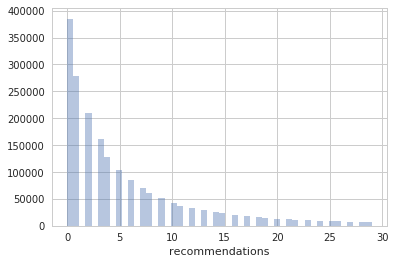

In [5]:
# Target is recommendations, heavily slanted distribution
sns.distplot(df.recommendations.loc[df.recommendations < 30], kde = False)

Take a look at the bottom of the distribution, dominated by zeros:

In [6]:
print(df.recommendations.value_counts().head(10))

0.0    385013
1.0    278544
2.0    209162
3.0    162014
4.0    127792
5.0    103044
6.0     84626
7.0     71178
8.0     60258
9.0     51066
Name: recommendations, dtype: int64


and the top:

In [7]:
df.recommendations.sort_values().tail(10)

504511      7709.0
77679       7938.0
696412      8124.0
1027939     8125.0
1987659     8160.0
696432      8514.0
2062146     8639.0
1738646     8713.0
915605      9279.0
2062163    10472.0
Name: recommendations, dtype: float64

So the vast majority have fewer than 15 upvotes and there are only a handful with over 6000. Let's slice the variable into four roughly equal sized categories, and rename it to **recs**. We also change it to an _int_ that ranges 1 to 4 in order to make throwing it into a variety of models a bit easier (including multinomial logistic regression). (The alternative is a labeled categorical variable)

In [8]:
# cut the interval into 4 bins
df['reclabels'] = pd.cut(df.recommendations, bins=(0, 1, 3, 9, 100000),
                    include_lowest=True, right=False)
print(df.reclabels.value_counts(normalize=True).round(3))
# change it to int
df['recs'] = df.reclabels.cat.codes


[3, 9)         0.292
[9, 100000)    0.290
[1, 3)         0.234
[0, 1)         0.184
Name: reclabels, dtype: float64


The distribution of the new categorical variable looks much more balanced:

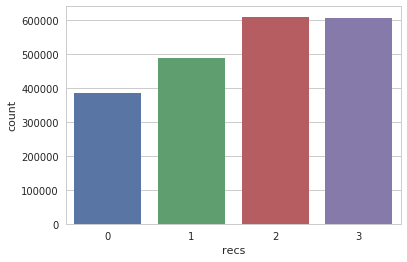

In [9]:
sns.countplot(df.recs)



Turn categorical to dummies <a name='todummies'></a>

We'll do it using a wrapper around the useful Pandas function **get_dummies**. (There is an analogous function in Scikit-learn.) Note the fact that we drop one (usually the first) category in order to prevent colinearity issues (at least in the case of Logistic Regression for example). Look at non-numeric features:

In [10]:
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086862 entries, 0 to 2086861
Data columns (total 18 columns):
articleID          object
commentBody        object
commentTitle       object
commentType        object
newDesk            object
permID             object
picURL             object
sectionName        object
status             object
typeOfMaterial     object
userDisplayName    object
userLocation       object
byline             object
headline           object
keywords           object
pubDate            object
snippet            object
documentType       object
dtypes: object(18)
memory usage: 286.6+ MB


Of these we'll pick the potentially useful ones and leave the raw text features (**byline**, **headline**, **keywords**, and **commentBody**) for now. One of the categorical variables in the dataset (whether or not the comment has been recommended by the NYTimes staff, **editorsSelection**) is really coded as _int_, so we include it here. We'll also ignore several features (such as **userLocation** and **userDisplayName**) for now, which contain quite a bit of noise, though they could be utilized later.

In [11]:
# one hot encoding function for categorical
def OneHotEncoding(list_of_variables, data=df):
    '''One-hot-encodes a list of string (categorical) variables from a dataframe
    into binary features for modeling. It drops the last category to prevent colinearity problems (reference category).
    Outputs a dataframe the same number of rows as original df.'''
    new_df = []
    for var in list_of_variables:
        new_df.append(pd.get_dummies(
            data[var],
            drop_first=True,
            prefix=(var)))
    return pd.concat(new_df, axis=1)

# 
list_of_categorical = ['editorsSelection',
                       'newDesk',
                       'sectionName',
                       'typeOfMaterial',
                       'commentType',
                       'documentType'
]


df_temp = OneHotEncoding(list_of_categorical, data=df)
print(df_temp.shape)
print(df_temp.info())


(2086862, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086862 entries, 0 to 2086861
Columns: 121 entries, editorsSelection_1 to documentType_blogpost
dtypes: uint8(121)
memory usage: 240.8 MB
None


And let's grab the numeric features which could be meaningful and combine into a new dataframe. These are most if not all of the numerical features which could be related to the target: length measured in words of the article, page of the newspaper it appeared on, whether the author of the comments is a member of the NYTimes staff and so on. Again, we will not include the number of responses a comment has received as that should be a consequence, rather than a predictor of upvotes.

In [12]:
list_of_numeric = ['approveDate',
                   'articleWordCount',
                   'depth',
                   'printPage',
                   'timespeople',
                   'trusted',
                   'sharing',
                   'recs'
]
# combine the two types of features
X_full = pd.concat([df_temp, df[list_of_numeric]], axis=1)
X_full.reset_index(drop=True, inplace=True)
del df_temp
print(X_full.shape)



(2086862, 129)


One last housekeeping chore: the raw text of the comment bodies, which we will use later, contain some html markup which we should remove (as suggested by the original author of the dataset). We do that with a simple wrapper:

In [13]:
# This list of artefacts to remove is from the original dataset exploration post by Aashita Kesarwani https://www.kaggle.com/aashita/exploratory-data-analysis-of-comments-on-nyt/code
replacements = {"(<br/>)": "",
                "(<br/>)": "",
                '(<a).*(>).*(</a>)': '',
                '(&amp)': '',
                '(&gt)': '',
                '(&gt)': '',
                '(&lt)': '',
                '(\xa0)': ' ',
                }


def preprocess(commentBody):
    '''Function to clean up the body of comments by removing artefacts'''
    for pattern, replacement in replacements.items():
        commentBody = commentBody.str.replace(pattern, replacement)
    return commentBody


# clean up the comments
df['commentBody'] = preprocess(df.commentBody)


To wrap up the data loading, let's create a smaller dev set (only 5% or about 100K comments) that we can play with without waiting for long executions. We'll keep the index so that we may pull more features from the full dataset later (not run here).

In [14]:
dev_set_size = .05
dev_set_index = X_full.sample(frac=dev_set_size, random_state=12).index
X = X_full.loc[dev_set_index, :]
print(X.info())
print(X.shape)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104343 entries, 454762 to 846424
Columns: 129 entries, editorsSelection_1 to recs
dtypes: float64(5), int64(2), int8(1), uint8(121)
memory usage: 18.5 MB
None
(104343, 129)


Initial prediction <a name='initpredict'></a>

First, let's load the libraries we will use for this and try to fit a simple multinomial logistic model. To fit the logistic regression we will need to remove features that have no variance (rare categories that end up with no examples because of our reduced sample, for example) or are extremely highly correlated with other features. Both of these pose problems for the simple logistic model (extreme or perfect multicolinearity) and are generally not going to contribute much to the prediction anyway.


In [15]:
from scipy import stats
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as st
from xgboost.sklearn import XGBClassifier
import xgboost
scaler_standard = StandardScaler()
################################################################################



Next, let's create a simple function that reports the highest correlations within a dataset. We need it in order to eliminate features that are highly correlated and we'll be using it during the feature creation phase.

In [16]:
def top_correlations(df, n=20, abbreviate=True):
    '''Display top n correlations less than 1 from a pd.DataFrame'''
    original_names = df.columns
    if abbreviate:
        df.columns = [str(x)[:25] + '...' if len(x) >
                      25 else x for x in original_names]
    corrs = df.corr().unstack()
    corrs = corrs.reindex(corrs.abs().sort_values(ascending=False).index)
    corrs = corrs[corrs != 1]
    df.columns = original_names
    return corrs.iloc[::2].head(n)

top_correlations(X)

depth                         commentType_userReply      0.989546
sectionName_Book Review       newDesk_BookReview         0.984232
typeOfMaterial_Op-Ed          newDesk_OpEd               0.969793
typeOfMaterial_Letter         newDesk_Letters            0.951944
typeOfMaterial_Editorial      newDesk_Editorial          0.945840
typeOfMaterial_Op-Ed          typeOfMaterial_News       -0.812191
typeOfMaterial_News           newDesk_OpEd              -0.806177
sectionName_The Daily         newDesk_Podcasts           0.774582
sectionName_Retirement        newDesk_SpecialSections    0.752679
documentType_blogpost         newDesk_Unknown            0.698441
typeOfMaterial_Blog           newDesk_Unknown            0.698441
typeOfMaterial_Obituary (...  newDesk_Obits              0.674114
sectionName_Television        newDesk_Culture            0.574249
articleWordCount              newDesk_Magazine           0.567521
sectionName_Unknown           sectionName_Politics      -0.560913
newDesk_We

Evidently many of the section and news desk categories largely overlap. Also, the feature **depth** which measures whether a comment is a reply to another comment or a reply to a reply, etc (level 1 is an original comment, level 2 is a response and so on) unsurprisingly overlaps with the 'userReply' value of **commentType**. For now we'll solve this be eliminating one of each pair, preferring to keep the more informative feature **depth** and eliminating all **newDesk** features, as the original variable has more missing values.

In [17]:
# do not use inplace here, we want a copy!                                                  
X = X.drop(['commentType_userReply',
            'typeOfMaterial_Op-Ed'],        
           axis=1)
X = X.drop(list(X.filter(regex='newDesk')), axis=1)
top_correlations(X)

sectionName_Unknown        sectionName_Politics           -0.560913
sectionName_Politics       typeOfMaterial_News             0.468780
typeOfMaterial_News        printPage                      -0.446288
                           sectionName_Unknown            -0.396765
printPage                  sectionName_Unknown             0.388485
recs                       depth                          -0.378531
sectionName_Australia      typeOfMaterial_Biography        0.377921
printPage                  typeOfMaterial_Editorial        0.303589
typeOfMaterial_Editorial   typeOfMaterial_News            -0.303015
typeOfMaterial_News        articleWordCount                0.299464
typeOfMaterial_Blog        sectionName_Room For Deba...    0.299045
documentType_blogpost      sectionName_Room For Deba...    0.299045
typeOfMaterial_Review      sectionName_Television          0.298029
typeOfMaterial_News        sectionName_Sunday Review      -0.291467
printPage                  sectionName_Politics 

First fit, Multinomial Logistic: <a name='logit'></a>

We separate the target and predictors, split into a train and test set, which we'll consider a hold-out set and not train on, and remove all features with zero variance within a category (otherwise our logistic regression optimization will not converge with the default settings).

In [18]:
# separate out the target
predictors = X.columns[X.columns != 'recs']

X_train, X_test, y_train, y_test = train_test_split(
    X[predictors], X['recs'], test_size=0.25, random_state=12)

# check for no variance within category of the target (problem for fitting regression)
variance_per_category = X_train.groupby(y_train).var() == 0
novariance = variance_per_category.sum() > 0
X_train.drop(X_train.columns[novariance],
             axis=1,
             inplace=True)
X_test.drop(X_test.columns[novariance],
             axis=1,
             inplace=True)



In [19]:
# fit 
# This is equivalent to using SKlearn's MLogit with 'newton-cg' solver
# LogisticRegression(multi_class='multinomial', solver='newton-cg'),
X_logit = st.add_constant(X_train, prepend=False)
MLogit = st.MNLogit(y_train, X_logit)
logit_fit = MLogit.fit()
# this is necessary for the summary:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# print(logit_fit.summary())
logit_y_hat = logit_fit.predict(exog=st.add_constant(X_test, prepend=False))
# need to convert it to actual predictions as these are probabilities
logit_y_hat = logit_y_hat.idxmax(axis=1)
print(classification_report(y_test, logit_y_hat))
print('MLogit accuracy is about %.2f' % accuracy_score(y_test, logit_y_hat))




Optimization terminated successfully.
         Current function value: 1.261488
         Iterations 7
             precision    recall  f1-score   support

          0       0.41      0.39      0.40      4893
          1       0.35      0.15      0.21      6025
          2       0.33      0.33      0.33      7506
          3       0.43      0.64      0.51      7662

avg / total       0.38      0.39      0.37     26086

MLogit accuracy is about 0.39


OK, now we have our first (simple) fit and the first accuracy score - the model classified about 39% of cases correctly, which is an improvement of about 10% over the baseline (constant) model. The classification report shows that the model has the greatest amount of trouble guessing the second category (One or two upvotes), and is considerably better at guessing the fourth (most popular) category (recall column reports the share of cases of each category the classifier was able to correctly identify). Of all of the comments which received between one and two upvotes, our logistic regression classifier was able to recall only about 15%, in contrast to almost 70% for the fourth category (more than eight upvotes).
 
Without delving too deeply in the interpretation of the coefficients (uncomment if you want to take a look, long output...), it seems like the numeric features generally had the greatest impact. We'll say more about them in the next section, but these are features such as the length of the original article, the **depth** of the comment, whether the comment was recommended by the NYTimes staff (**editorSelection**), posted by NYTimes staff members or trusted users. While the various categories derived from the **sectionName** variable generally weren't that important, there were a few very popular categories there - for example 'Family' and 'Sunday Review.' Of course, all of the coefficients here are to be interpreted relative to the omitted reference category, but our focus here is on prediction so we won't dwell on the coefficients.

A bag of classifiers <a name='classifiers'></a>

Next, let's create a bag of classifiers. We are somewhat agnostic as to the most appropriate one at this stage, so we'll include several. In addition to logistic regression, we'll do Ridge regression (essentially a penalized regression), nearest neighbors and two ensemble models (Random Forest and Extreme Gradient Boost). Feel free to drop in your favorite classifier in the mix. I like XGB both for speed (run on a GPU it is quite fast), which allows more experiments, and for the fact that it can report feature importance - which features were present in more trees and how much gain in coverage did each provide. We won't do much model tuning at this stage, relying on the rather conservative default parameter values baked into Scikit-learn.

In [20]:
models = [('MLogit', LogisticRegression(n_jobs=-1)),
          ('Ridge', RidgeClassifier()),
          ('KNN', KNeighborsClassifier(n_jobs=-1)),
          ('RandomForest', RandomForestClassifier(n_jobs=-1)),
          ('XGB', XGBClassifier(tree_method='gpu_hist',
                                n_estimators=50)),
          ]

Let's put together a pipeline to report the scores on each of our these classifiers. It will allow us to compare classification performance after the feature engineering stage. To be on the safe side, we re-scale the data with Scikit-learn's standard scaler (center at zero and divide by standard deviation), although given the classifier families we chose this is not strictly necessary.

In [21]:
def predict_recs(X_train=X_train, 
                 y_train=y_train,
                 X_test=X_test,
                 y_test=y_test,
                 models=models,
          target_names=['None', '1 or 2', '3 to 8', '9 or more']):
    '''Fits and scores models'''
    Accuracy = {}
    for name, model in models:
        pipe = make_pipeline(scaler_standard, model)
        print()
        print('\nFitting ' + name)
        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_test)
        Accuracy[name] = np.round(accuracy_score(
            y_test, y_hat), 4)
        print('Accuracy of %s: %.4f' % (name, Accuracy[name]))
        print('\nClassification report:\n')
        print(classification_report(
            y_test, y_hat, target_names=target_names))
        y_hat_bin = label_binarize(y_hat, range(3))
        y_true_bin = label_binarize(y_test, range(3))
        ROC_AUC_score = roc_auc_score(y_true_bin, y_hat_bin)
        print('ROC_AUC_score: %.4f' % ROC_AUC_score)
        # print(confusion_matrix(
        #     y_test, y_hat))
    return Accuracy


# predict with only existing features
minimal_features = predict_recs(X_train, y_train)




Fitting MLogit
Accuracy of MLogit: 0.3893

Classification report:

             precision    recall  f1-score   support

       None       0.41      0.40      0.40      4893
     1 or 2       0.35      0.14      0.20      6025
     3 to 8       0.34      0.30      0.32      7506
  9 or more       0.42      0.67      0.51      7662

avg / total       0.38      0.39      0.36     26086

ROC_AUC_score: 0.5650


Fitting Ridge
Accuracy of Ridge: 0.3823

Classification report:

             precision    recall  f1-score   support

       None       0.40      0.43      0.42      4893
     1 or 2       0.36      0.10      0.16      6025
     3 to 8       0.34      0.18      0.23      7506
  9 or more       0.39      0.77      0.52      7662

avg / total       0.37      0.38      0.33     26086

ROC_AUC_score: 0.5622


Fitting KNN
Accuracy of KNN: 0.4086

Classification report:

             precision    recall  f1-score   support

       None       0.41      0.49      0.44      4893
     1 o

Some of our models did a little better than others, notably Random Forest seems to give the best predictions, at least at this stage. All of them had trouble with the second category, perhaps because it is difficult in principle to identify comments which received one-to-two upvotes as opposed to zero or more than two. 

Feature Engineering <a name='featureengineering'></a>

Time to create some meaningful features! We'll start with the numeric features that are already in the dataset and which showed much promise in the simple logistic model.

We will create features only on the dev set for now, which would take quite a bit less time. Eventually we would like to utilize the full data that we have. In order to speed things up a bit, let's use some multiprocessing (ie all of the cores we have available). I wrote a little function wrapper that spreads the task over as many cores as the system makes available and displays a nice progress bar so we know how long it will take. The overhead involved with multiprocessing usually makes it less time efficient to bother, but with a dataset of 2 million rows, it will tend to be faster. (We won't run it )


In [22]:
from multiprocessing import cpu_count, Pool
from tqdm import tqdm_notebook

def multip(func, iterable):
    '''Simple wrapper for multiprocessing a function over an iterable. Preserves order.'''
    with Pool(cpu_count()) as pool:
        out = list(tqdm_notebook(pool.imap(func, iterable),
                        total=len(iterable),
                        mininterval=1))
    return out


Features based on the original variables <a name='originalvars'></a>

The original numeric features in the data contain information on some potentially important attributes of both comments and articles. We care about the article features simply because some articles are much more likely to garner more attention. Consequently, the comments on these articles will tend to get more upvotes.


reply <a name='originalvars'></a>

**inReplyTo** - an original variable which simply tells us which comment the current comment is responding to (based on the ID of the comment) or holds a value of zero if it is not a response.
One way to extract a useful feature from this would be to create a variable which takes a value of the number of recommendations/upvotes which the original comments obtained and a value of zero if this is not a reply at all. The expectation is responding to a popular comment should get you more visibility and, by extension, more upvotes. We can think of this as the Reddit top-comment hijacking strategy, which will be familiar to anyone who has used Reddit, though the visibility of the responses is nowhere near as prominent as it is on Reddit.

In [23]:
# feature is zero if not a reply and number of upvotes of original comment if it is a reply
def replycounter(x):
    if x == 0:
        return 0
    elif x != 0:
        return df.recommendations.at[int(np.where(df.commentID == x)[0])]
    else:
        return np.nan

# run only on the dev set for speed
X['reply'] = multip(replycounter, df.inReplyTo[dev_set_index])

# uncomment this for full set
# X_full['reply'] = multip(replycounter, df.inReplyTo)

print(X.reply.describe())



count    104343.000000
mean         30.265471
std         175.474726
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8160.000000
Name: reply, dtype: float64


Another 'object'-type variable which we could utilize is **byline**, which reports the authors of an article. <a name='byline'></a>
Here's a quick look:

In [24]:
df.byline.value_counts().head(20)

By THE EDITORIAL BOARD       140540
By PAUL KRUGMAN               66631
By DAVID BROOKS               55968
By CHARLES M. BLOW            50041
By FRANK BRUNI                44710
By NICHOLAS KRISTOF           40030
By ROSS DOUTHAT               36244
By GAIL COLLINS               32452
By DAVID LEONHARDT            25004
By ROGER COHEN                23732
By THE LEARNING NETWORK       20692
By THOMAS L. FRIEDMAN         20481
By PETER BAKER                19019
By DEB AMLEN                  18411
By JULIE HIRSCHFELD DAVIS     17310
By MICHELLE GOLDBERG          17250
By MAUREEN DOWD               17225
By BRET STEPHENS              16457
By THOMAS B. EDSALL           15487
By MICHAEL D. SHEAR           14170
Name: byline, dtype: int64

Unsurprisingly, some authors tend to generate many more comments than others (the top being the Editorial Board of course, followed by many of the op-ed contributors). One quick and easy way to make use of this is to simply get dummies for each of the top authors, in our case we can do it for the top 20, although obviously one could go for more.

In [25]:
# get column names of top 20 authors
top_authors = list(df.byline.value_counts().head(20).index)

# deliberately picked 'Another Author' as the replacement string as it should end up being removed as the first category
def author_pick(x):
    if x in top_authors:
        return x
    else:
        return 'Another Author'


series_temp = multip(author_pick, df.byline)
df_temp = OneHotEncoding(['author'], pd.DataFrame(
    series_temp, columns=['author']))

# add them to the full set
X_full = pd.concat([X_full, df_temp], axis=1)
# and place them in the dev set 
X = pd.concat([X, df_temp.loc[dev_set_index, :]], axis=1)
del df_temp



Next, I noticed in the MLogit output that one of the time variables seemed to have a large impact - **approveDate**. This variable effectively report the exact timing of a comment being approved, and therefore appearing online - kind of like the publication time of a comment. Let's take a peek at what it looks like:

In [26]:
df.approveDate.head()

0    1491245186
1    1491188619
2    1491188617
3    1491167820
4    1491167815
Name: approveDate, dtype: int64

Ooh, that's ugly - and meaningless at first glance. After some digging around we figure out that this variable is in Posix format: it reports seconds since 1970-01-01. Let's create a few features that can be meaningful for us: 

1. **approveHour** - Hour of the day in which a comment was published. We expect, for example, that people are reading and responding to online content more during the day than at night. Categorical.

2. **approveDay**  - Same for day of the week, perhaps weekends are more procrastination-prone than weekdays. Categorical.

2. **hoursAfterArticle** - The number of hours elapsed between an article's publication and the corresponding comments' approval (and therefore publication). We can use the **pubDate** original variable from the articles dataset for the former. That one is coded as a string, so we'll have to convert it to a time format as well. We expect that if too much time passes after an article is published, it will simply get too few eyeballs. Continuous.
 

In [27]:
# fix article publication date
print(df.pubDate.head())
df.pubDate = pd.to_datetime(df.pubDate)
print(df.pubDate.head())

0    2017-04-01 00:15:41
1    2017-04-01 00:15:41
2    2017-04-01 00:15:41
3    2017-04-01 00:15:41
4    2017-04-01 00:15:41
Name: pubDate, dtype: object
0   2017-04-01 00:15:41
1   2017-04-01 00:15:41
2   2017-04-01 00:15:41
3   2017-04-01 00:15:41
4   2017-04-01 00:15:41
Name: pubDate, dtype: datetime64[ns]


In [28]:
# convert all time columns from posix to regular format (we'll only use one of them)
print(df.approveDate.head())
timecolumns = ['approveDate', 'createDate', 'updateDate']
df[['approveTime', 'createTime', 'updateTime']] = df[timecolumns].apply(
    lambda t: pd.to_datetime(t, unit='s'))
print(df.approveTime.head())
print(df.approveTime.describe())

0    1491245186
1    1491188619
2    1491188617
3    1491167820
4    1491167815
Name: approveDate, dtype: int64
0   2017-04-03 18:46:26
1   2017-04-03 03:03:39
2   2017-04-03 03:03:37
3   2017-04-02 21:17:00
4   2017-04-02 21:16:55
Name: approveTime, dtype: datetime64[ns]
count                 2086862
unique                1233915
top       2017-04-26 15:53:49
freq                       42
first     2017-01-02 00:51:07
last      2018-05-02 03:50:35
Name: approveTime, dtype: object


In [29]:
# change the index to approveTime
df.index = df.approveTime
# sample by hour, (to the next hour)
df['approveHour'] = [
    str(x) + 'AM' if x < 12 else str(x - 12) + 'PM' for x in df.index.hour]
# sample by day
df['approveDay'] = df.index.weekday_name
df.reset_index(drop=True, inplace=True)
print(df.approveHour.head())
# add dummies for both to df using the function we built earlier
df_temp = OneHotEncoding(['approveHour',
                          'approveDay'])
# combine the two types of features and remove the old one
X_full = pd.concat([X_full, df_temp], axis=1)
del X_full['approveDate']
# and place them in the dev set as well
X = pd.concat([X, df_temp.loc[dev_set_index, :]], axis=1)
del X['approveDate']
print(X.shape)
del df_temp


0    6PM
1    3AM
2    3AM
3    9PM
4    9PM
Name: approveHour, dtype: object
(104343, 133)


In [30]:
# create a feature for time of posting of comment since article published
df['timeDelta'] = df.approveTime - df.pubDate
# convert this timedelta object to hours (downsample)
df['hoursAfterArticle'] = df.timeDelta.astype(
    'timedelta64[h]')

print(df.hoursAfterArticle.head())
print(df.hoursAfterArticle.describe())

0    66.0
1    50.0
2    50.0
3    45.0
4    45.0
Name: hoursAfterArticle, dtype: float64
count    2.086862e+06
mean     2.956882e+01
std      2.166681e+02
min     -8.000000e+00
25%      7.000000e+00
50%      1.300000e+01
75%      2.000000e+01
max      1.030800e+04
Name: hoursAfterArticle, dtype: float64


Ooops! Negative hours... Hmm, the minimum value of the new variable is -8. Since we haven't yet discovered time travel, this means that either we are experiencing issues with time zones or there's simply some errors in the data - some articles appeared before their publication time or some comments' approval time was misrecorded. Either way, the issue affects very few cases, so we'll simply set all of the negative values to zero, noting the fact that we may be introducing some noise and even bias here. 


In [31]:
print(df[df.hoursAfterArticle < 0].shape[0])
df.loc[df.hoursAfterArticle < 0, 'hoursAfterArticle'] = 0
# And assign to the large DataFrame:
X_full['hoursAfterArticle'] = df['hoursAfterArticle']
# and the small dev set
X['hoursAfterArticle'] = X_full.loc[dev_set_index, 'hoursAfterArticle']
print(X.hoursAfterArticle.describe())

1373
count    104343.000000
mean         30.577068
std         230.122268
min           0.000000
25%           7.000000
50%          13.000000
75%          20.000000
max       10182.000000
Name: hoursAfterArticle, dtype: float64


Features based on raw text data  <a name='textdata'></a>

OK, here comes the messy raw text manipulation. We have so far not utilized the actual body of comments as well as some of the raw text data we possess about the articles. So let's do that.
My intuition about comment upvotes is that generally comments will be more popular when they read like their author put in time and effort to write them, made them more informative, polished and balanced. This could mean quite a few different things, but here's one way to approach the quantification problem. We expect that popular comments will not be too short (low effort!), will use more sophisticated language (ie more rare words, longer words, longer sentences, etc.), will have no or few spelling mistakes (no excuses now that most browsers offer spell-check out of the box), and will not be too negative-sounding (positive or neutral sentiment). These are of course little more than hunches at this stage.


A NYTimes vocabulary <a name='vocab'></a>

To get measures of all of these, we'll use a few external libraries and one more dataset. I would like to measure the extent to which comments use _the language of the NYTimes_. To that effect, it makes sense to create a vocabulary based on the text of NYTimes articles. I found another wonderful dataset on Kaggle - available 
[here](https://www.kaggle.com/nzalake52/new-york-times-articles/data). It contains over 8,000 articles, and while not very well documented, should more than suffice for our purposes here.

For both speed and ease of use, we can use the built-in tokenizer in Scikit-learn, tuning it a bit in order to get only words. We tokenize the raw text files of the articles' bodies immediately upon reading them, append them to a list and transform it into a Pandas Series (for convenience). Then, we fit the tokenizer to them to learn the frequency of each word's usage. Frequency is important here, as we want to get a sense whether a comment uses rare English words.

In [32]:
# Get some NYTimes articles to train on
counter = CountVectorizer(stop_words='english',
                          strip_accents='unicode',
                          analyzer='word',
                          min_df=1)
# first get the tokenizer tool from CountVectorizer
tokenize = counter.build_analyzer()
docs = []
doc = ''

with open('./Data/nytimes_news_articles.txt', encoding='utf-8') as file:
    for line in file:
        if line.startswith('URL'):
            if doc != '':
                docs.append(' '.join(tokenize(doc)))
            doc = ''
        else:
            doc += line

docs = pd.Series(docs)
print(docs.sample())
# fit the CountVectorizer to the data
counter.fit(docs)


2846    years revival glass menagerie return broadway starring time academy award winner sally field ama...
dtype: object


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Whenever we tokenize it is a good idea to take a look at the beginning and end of the token lists, remembering that raw text is messy business. A useful little built-in function allows us to explore the dictionary we are building:

In [33]:
token_names = counter.get_feature_names()
# last 10 tokens
print(token_names[-10:])


['힘들어지고', '힘을', '힘이', '发烧一次', '富二代', '百毒', '素质', '聪明一次', '贤二机器僧', '高洪波']


Uh-oh! This doesn't look like english!
After some digging around, the culprit is several articles in Asian characters. 
Let's identify and remove all of the articles in which a large portion of the words are not in English:

In [34]:
def score_English(article):
    '''Report the percent of words in a document which are not English (ASCI)'''
    if not article:
        return np.nan
    else:
        n_english = 0
        for token in article:
            try:
                token.encode('ascii')
            except UnicodeEncodeError:
                continue
            else:
                n_english += 1
        return np.round(n_english / len(article) * 100, 2)


percent_english = docs.apply(score_English)
print(percent_english.sort_values().head(10))

6109    12.66
8606    13.01
3632    13.01
4550    13.17
2671    13.53
7998    13.62
1097    13.84
7590    14.94
8506    99.68
7693    99.85
dtype: float64


We remove the non-English articles and refit:

In [35]:
# remove them:
docs = docs[percent_english > 20]
# and try again:
counter.fit(docs)
# get the token names again
feature_names = counter.get_feature_names()
# the end looks good now:
print(feature_names[-30:])


['zuther', 'zuwarah', 'zuyu', 'zuyus', 'zverev', 'zvi', 'zvolen', 'zwd', 'zweden', 'zweibel', 'zweig', 'zwick', 'zwicker', 'zwilling', 'zwirner', 'zwolski', 'zyaratgah', 'zych', 'zydeco', 'zyklon', 'zylinski', 'zynga', 'zytiga', 'zytkow', 'zywicki', 'zz', '发烧一次', '百毒', '聪明一次', '贤二机器僧']


And the beginning of the list is full of numbers, let's get rid of those as well:

In [36]:
print(feature_names[:10])
vocab = feature_names[2330:]
print(vocab[:10])

['00', '000', '0000', '0000364334', '0001', '000s', '000th', '001', '0017', '002']
['____________________________________________________', '_idkmatilda', 'a1', 'a10', 'a16', 'a1c', 'a2', 'a20', 'a24', 'a2z']


Obviously we are not quite done yet - the tokenizer picked up quite a few non-words, let's run each by a proper English dictionary and eliminate the non-words.

In [37]:
import enchant
us_english = enchant.Dict("en_US")
# create a clean copy of the dictionary only with recognized English words

vocab = [word for word in vocab if us_english.check(word)]
print(vocab[:10], vocab[-10:])

['ab', 'aback', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abasement', 'abashed'] ['zoological', 'zoologist', 'zoology', 'zoom', 'zoomed', 'zooming', 'zooms', 'zoos', 'zucchini', 'zydeco']


OK, this looks much better, we have a proper english vocabulary based on the NYTimes. This is why did all of the work: using an IDF counter we can get the frequency of each recognized word and use that to build several features based on the diversity of a comment's vocabulary.

All of this will be built on a measure commonly used in document classification in Natural Language Processing tasks called 'IDF' or 'inverse document frequency.' It measures how infrequently a word is used in a body of documents (how rare the word is), which is quite useful for the typical document classification task, usually normalized by multiplying by term frequency, get 'TFIDF.' This is not what we need here though - we simply want IDF, so here's what it looks like and how to get it.
First, we train a a tokenizer to the docs using only our cleaned up vocabulary:

In [38]:
tfidf = TfidfVectorizer(norm=None,
                        vocabulary=vocab,
                        min_df=1,
                        )

tfidf.fit(docs)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=['ab', 'aback', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abasement', 'abashed', 'abate', 'abated', 'abatement', 'abatements', 'abating', 'abbey', 'abbot', 'abbreviated', 'abbreviation', 'abbreviations', 'abdicate', 'abdicated', 'abdicating', 'abdication'...ogical', 'zoologist', 'zoology', 'zoom', 'zoomed', 'zooming', 'zooms', 'zoos', 'zucchini', 'zydeco'])

Now, let's see if it is behaving as expected. Here's a very simple example that shows us the IDF value for a word that appears in a given percentage of documents, using the conventional formula for IDF ([wiki](https://en.wikipedia.org/wiki/Tf-idf)):

In [39]:
# check an individual word's idf:
num_docs = 10000
doc_freq = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
idf = [np.log((1 + num_docs)/(1 + x)) + 1 for x in doc_freq]
for x, y in zip(doc_freq, idf):
    print('\nA term which appears in %.2f%% of documents has an IDF of %.2f.' %
          (x/num_docs*100, y))


A term which appears in 0.01% of documents has an IDF of 9.52.

A term which appears in 0.05% of documents has an IDF of 8.42.

A term which appears in 0.10% of documents has an IDF of 7.81.

A term which appears in 0.50% of documents has an IDF of 6.28.

A term which appears in 1.00% of documents has an IDF of 5.60.

A term which appears in 5.00% of documents has an IDF of 3.99.

A term which appears in 10.00% of documents has an IDF of 3.30.

A term which appears in 50.00% of documents has an IDF of 1.69.

A term which appears in 100.00% of documents has an IDF of 1.00.


OK, now let's see run some English words, in decreasing order of frequency, by our trained vocabulary:

In [40]:
def word_idf(word, tfidf=tfidf):
    idf = np.round(tfidf.idf_[tfidf.vocabulary_[word]], 2)
    print('\n\'' + word + '\' has an IDF of %.2f.' % idf)


word_idf('zealot')
word_idf('edifice')
word_idf('prolific')
word_idf('simple')
word_idf('good')
word_idf('like')



'zealot' has an IDF of 8.70.

'edifice' has an IDF of 7.89.

'prolific' has an IDF of 5.86.

'simple' has an IDF of 3.87.

'good' has an IDF of 2.23.

'like' has an IDF of 1.53.


That will do. 
Let's get back to the feature engineering.

Using our trained IDF counter, we can transform all comments into a matrix of IDF scores (each row is an array of the IDF scores of the the tokens present in a comment). Then we can use that matrix (and some additional wizardry) to create a bin count - a count of each IDF integer. Think about this as the vocabulary rarity profile of a comment. While we could just rely on the mean IDF (or one of the other basic stats), doing a bin count allows us to probe a little deeper - two comments might have a very different IDF profile yet have the same mean IDF.
For additional convenience, we create a simple summarizer function which reports a count, minimum, mean, standard deviation and maximum value given an array. In case a comment contains no recognizable words, we simply assign a value of zero to all measures. A safer choice here would be to exclude the comment altogether - but very few comments fall in this category so are are not worried about bias too much (especially given the size of the full dataset).

In [41]:
# grab only the dev set comments:
comments = df.commentBody[dev_set_index]
# uncomment next line for full set:
# comments = df.commentBody

def summarizer(array):
    '''Simple summary from an array: count, min, mean, stand dev, max'''
    return np.array([array.size,
                     np.min(array),
                     np.mean(array),
                     np.std(array),
                     np.max(array)])


def comment_idf_profile(row):
    '''Summarize idf scores for each recognized token in a comment and provide a bin count percent of idf scores.'''
    tokens = comment_tf[row, :].data
    if tokens.size != 0:
        idfs = comment_matrix[row, :].data / tokens
        out_summary = summarizer(idfs)
        out_bin = np.bincount(idfs.astype(int), minlength=10)[1:]
        out_bin_percent = out_bin / len(tokens)
        output = np.hstack([out_summary, out_bin_percent])
    else:
        output = np.zeros(14)
    return output

comment_matrix = tfidf.transform(comments)
comment_matrix.sort_indices()  # it's inplace
counter = CountVectorizer(vocabulary=vocab,
                          min_df=1)
comment_tf = counter.transform(comments)
# comment_tokens = list(map(tokenize, comments))


In [42]:
scored_df = multip(comment_idf_profile, range(comment_matrix.shape[0]))
scored_df = pd.DataFrame(scored_df)
idf_labs_percent = ['Idf' + str(x) + 'Percent' for x in range(1, 10)]
scored_df.columns = ['recognizedWordCount',
                     'MinIdf',
                     'MeanIdf',
                     'StdDevIdf',
                     'MaxIdf'] + idf_labs_percent
# quick sanity check
print(scored_df.info())
print(scored_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104343 entries, 0 to 104342
Data columns (total 14 columns):
recognizedWordCount    104343 non-null float64
MinIdf                 104343 non-null float64
MeanIdf                104343 non-null float64
StdDevIdf              104343 non-null float64
MaxIdf                 104343 non-null float64
Idf1Percent            104343 non-null float64
Idf2Percent            104343 non-null float64
Idf3Percent            104343 non-null float64
Idf4Percent            104343 non-null float64
Idf5Percent            104343 non-null float64
Idf6Percent            104343 non-null float64
Idf7Percent            104343 non-null float64
Idf8Percent            104343 non-null float64
Idf9Percent            104343 non-null float64
dtypes: float64(14)
memory usage: 11.1 MB
None
       recognizedWordCount         MinIdf        MeanIdf      StdDevIdf  \
count        104343.000000  104343.000000  104343.000000  104343.000000   
mean             26.594597       

All in all, we ended up creating 14 new features, we won't worry about the correlations between them just yet, but we'll take a look at those before prediction. 

Time to throw in the kitchen sink! <a name='kitchensink'></a>

Let's create more features based on more of the indicators we are looking for. Relying on two NLP libraries (TextBlob and the conventional NLTK), we obtain a host of features: basic stats on words and word length, basic stats on sentences and sentence length, sentiment polarity (positive-negative) and subjectivity (subjective-objective) scores, spelling (percent of correctly spelled words), and even part-of-speech breakdown (how many nouns, adjectives, adverbs and so on as a percentage of all words.) The full list of parts-of-speech tags is available 
[here](https://www.clips.uantwerpen.be/pages/mbsp-tags).

For most of these features, our expectation is that generally comments should fall in an ideal range - not too short, nor too long in terms of sentence length and comment length; not too many adjectives but also not too few and so on. Of course, in terms of spelling we expect lower error rate to be better.

A few additional small considerations. We put all of these indicators in one large function simply to economize on the overhead associated with multiprocessing. Also, there is a little regular expression magic at the beginning of the function to fix a very common error - no space after end of sentence punctuation (.?!). We fix that because it leads to more noise in all of our features. We spell-check all words which are not 'proper nouns', meaning names, as that should generate more accurate counts. Finally, comments shorter that three characters are coded as all zeroes - they are simply too short to get much information. Again, one could also eliminate them out of the sample if worried about bias.

In [43]:
# get all the POS tags to create an array
from nltk.data import load
from nltk import FreqDist
from nltk.tokenize import WhitespaceTokenizer
from enchant.checker import SpellChecker
import re
from textblob import TextBlob
spell_checker = SpellChecker(us_english)
universal_tags = load('help/tagsets/upenn_tagset.pickle')
tags = universal_tags.keys()
tag_labels_percent = [label + '_Percent' for label in tags]


def comment_stats(comment):
    '''Report stats for a comment. Stats on sentences, words, part-of-speech tags as portion of the total, spelling and sentiment scores. Comments shorter than 3 characters output zeroes.'''
    if len(comment) < 3:
        return np.zeros(58)
    ################################################################################
    # insert space after period or comma if there isn't one already (common error)
    comment = re.sub(r'(?<=[.,?!])(?=[^\s])', r' ', comment)
    ################################################################################
    # sentence stats
    blob = TextBlob(comment)
    sentences = blob.sentences
    tokenized_sents = [sentence.words for sentence in sentences]
    sent_lengths = np.array([len(sentence)
                             for sentence in tokenized_sents])
    out_sent = summarizer(sent_lengths)
    ################################################################################
    # word stats
    word_lengths = np.array([len(word) for word in blob.words])
    if word_lengths.size == 0:
        return np.zeros(58)
    out_word = summarizer(word_lengths)
    ################################################################################
    # sentiment analysis: polarity and objectivity
    out_polarity = list(blob.sentiment)
    ################################################################################
    # spellcheck stats
    # replace most punctuation by space for whitespacetokenizer, leave apostrophes for contractions
    comment_nopunct = re.sub(r'[,.?!#():-="“”%$]', ' ', comment)
    blob_nopunct = TextBlob(comment_nopunct, tokenizer=WhitespaceTokenizer())
    non_NNP = [word for word, tag in blob_nopunct.tags if tag !=
               'NNP']
    if not non_NNP:
        out_spell = np.zeros(1)
    else:
        spell_errors = 0
        for word in non_NNP:
            try:
                spell_errors += not spell_checker.check(word.strip('\'\`'))
            except:
                spell_errors += 1
        out_spell = np.array(spell_errors / len(non_NNP))
    ################################################################################
    # part of speech stats
    fd = FreqDist(tag for (word, tag) in blob.tags)
    ordered_freqs = np.array(
        [fd[key] if key in fd.keys() else 0 for key in tags])
    out_pos_percent = np.squeeze(ordered_freqs / len(word_lengths))
    ################################################################################
    return np.hstack([out_word, out_sent, out_polarity, out_spell,
                      out_pos_percent])


comment_stats_df = multip(comment_stats, comments)


In [44]:
comment_stats_df = pd.DataFrame(comment_stats_df)
comment_stats_df.columns = ['WordCount',
                            'minWordLength',
                            'meanWordLength',
                            'stdDevWordLength',
                            'maxWordLength',
                            'SentCount',
                            'minSentLength',
                            'meanSentLength',
                            'stdDevSentLength',
                            'maxSentLength',
                            'commentPolarity',
                            'commentObjectivity',
                            'commentSpellErrorsPercent'] + tag_labels_percent
# quick sanity check
comment_stats_df.describe()
comment_stats_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104343 entries, 0 to 104342
Data columns (total 58 columns):
WordCount                    104343 non-null float64
minWordLength                104343 non-null float64
meanWordLength               104343 non-null float64
stdDevWordLength             104343 non-null float64
maxWordLength                104343 non-null float64
SentCount                    104343 non-null float64
minSentLength                104343 non-null float64
meanSentLength               104343 non-null float64
stdDevSentLength             104343 non-null float64
maxSentLength                104343 non-null float64
commentPolarity              104343 non-null float64
commentObjectivity           104343 non-null float64
commentSpellErrorsPercent    104343 non-null float64
LS_Percent                   104343 non-null float64
TO_Percent                   104343 non-null float64
VBN_Percent                  104343 non-null float64
''_Percent                   104343 non-n

In [45]:
# add the both sets of new features to the dev set
X = pd.concat([X.reset_index(drop=True),
               scored_df,
               comment_stats_df], axis=1)

# uncomment for full set
# X_full = pd.concat([X_full,
#                scored_df,
#                comment_stats_df], axis=1)


OK, before we continue with the feature engineering, let's do a small unit test: let's look at the body of a comment and see if the features we just created match.

In [46]:
print(comments.iloc[88888])
print()
print(X.iloc[88888, 83:143])
print(X.iloc[88888, 143:])


On top of the confusion and conflict, boys (and girls) must contend with bullying, and more importantly a tacit acceptance of bullying, porn viewing, isolation that comes with technology and dubious nutrition.Band-aid proposals until these kids do the work for us and get the AR-15s out of the classroom could be requirements to attend 1-2 hours a week (on a rotation basis or as elective) in middle and high school dedicated to:Drama exercises/public speaking/verbal articulationCivics (no brainer)Group talks/debates and outward bound/team building exercises where boys and girls are separated (transgenders get to choose which group)Meditation or a martial art

reply                                0.000000
author_By BRET STEPHENS              0.000000
author_By CHARLES M. BLOW            0.000000
author_By DAVID BROOKS               0.000000
author_By DAVID LEONHARDT            0.000000
author_By DEB AMLEN                  0.000000
author_By FRANK BRUNI                0.000000
author_By GAI

Great, it's a match: number of words, sentences, spelling, etc.

Final step in the feature engineering: Token features <a name='articletextdata'></a>

Basically, these are simply binary features of whether a certain token (usually word) is included or not. To economize on time and memory, we'll limit ourselves to the top (most frequent) 50 tokens. Obviously, we could easily increase the count or eliminate the limitation altogether, but we would end up with many more features.
The first one will be based on the list of keywords that came with each article, **keywords**. Quite simply, our expectation here is that some keywords describing articles may be associated with more comments and upvotes in general (hot topics).
This is what they look like:

In [47]:
df.keywords.sample(5)

54478          ['Biological and Chemical Warfare', 'Reality Television', 'Trump, Donald J', 'Syria', 'Russia']
2077425    ['United States Politics and Government', 'Federal Budget (US)', 'Ryan, Paul D Jr', 'Trump, Dona...
1648858    ['Gun Control', 'Demonstrations, Protests and Riots', 'Voting and Voters', 'Parkland (Fla)', 'Na...
1651376    ['United States Politics and Government', 'Veterans', 'Appointments and Executive Changes', 'Vet...
1347153                        ['Democracy (Theory and Philosophy)', 'Books and Literature', 'Berry, Wendell']
Name: keywords, dtype: object

We simply tokenize the keyword lists, this time tuning the tokenizer to remove the artefacts of the lists and split on commas. Essentially, we are building a word list of the most commonly occurring keywords and record whether an article (and therefore all the comments attached to it) contains them in the description or not. We fit (train) on the full set but transform (count) only the dev set. The result is a sparse matrix, which we will convert to dense before the prediction. 

In [48]:
keywords = df.keywords.iloc[dev_set_index]

# # uncomment for full set
# keywords = df.keywords

def keyword_tokenizer(keyword):
    '''Split into keywords (phrases and remove all quotes and brackets)'''
    return [phrase.strip('\'\[\] ') for phrase in keyword.split('\',')]


counter_keywords = CountVectorizer(stop_words='english',
                                   analyzer='word',
                                   tokenizer=keyword_tokenizer,
                                   max_features=50)
counter_keywords.fit(df.keywords)
common_keywords = counter_keywords.transform(keywords)
keyword_features = counter_keywords.get_feature_names()
keyword_features = ['Keyword:"' + feature +
                    '"' for feature in keyword_features]
print(keyword_features)


['Keyword:""', 'Keyword:"appointments and executive changes"', 'Keyword:"blacks"', 'Keyword:"china"', 'Keyword:"classified information and state secrets"', 'Keyword:"clinton, hillary rodham"', 'Keyword:"comey, james b"', 'Keyword:"cyberwarfare and defense"', 'Keyword:"democratic party"', 'Keyword:"demonstrations, protests and riots"', 'Keyword:"discrimination"', 'Keyword:"espionage and intelligence services"', 'Keyword:"executive orders and memorandums"', 'Keyword:"federal budget (us)"', 'Keyword:"federal bureau of investigation"', 'Keyword:"global warming"', 'Keyword:"gun control"', 'Keyword:"health insurance and managed care"', 'Keyword:"house of representatives"', 'Keyword:"illegal immigration"', 'Keyword:"immigration and emigration"', 'Keyword:"international trade and world market"', 'Keyword:"justice department"', 'Keyword:"labor and jobs"', 'Keyword:"law and legislation"', 'Keyword:"mueller, robert s iii"', 'Keyword:"news and news media"', 'Keyword:"obama, barack"', 'Keyword:"par

Yep, this does seem like a list of hot topics in the news for the two periods the articles covered.

Finally, the last feature to be engineered is the same counter for most commonly occuring words, but this time applied to the comments themselves. How many times does a comment include the name 'Trump' for example? We'll be a little more generous and allow the top 100 such tokens to be counted (and again you could easily increase the number of tokens here). We will also exclude extremely common tokens - ones that appear in more than 30% of the comments and look for either single tokens or bigrams of tokens.  Warning: this will take a few minutes... 

In [49]:

# exclude very common words (appear in more than half the comments)
counter = CountVectorizer(stop_words='english',
                          analyzer='word',
                          ngram_range=(1, 2),
                          max_df=.3,
                          max_features=100,
                          )

counter.fit(df.commentBody)
common_tokens = counter.transform(comments)
token_names = counter.get_feature_names()
token_names = ['CommentWord:"' + feature + '"' for feature in token_names]
print(token_names)


['CommentWord:"actually"', 'CommentWord:"administration"', 'CommentWord:"america"', 'CommentWord:"american"', 'CommentWord:"americans"', 'CommentWord:"article"', 'CommentWord:"believe"', 'CommentWord:"best"', 'CommentWord:"better"', 'CommentWord:"care"', 'CommentWord:"change"', 'CommentWord:"children"', 'CommentWord:"come"', 'CommentWord:"congress"', 'CommentWord:"country"', 'CommentWord:"day"', 'CommentWord:"democrats"', 'CommentWord:"did"', 'CommentWord:"didn"', 'CommentWord:"does"', 'CommentWord:"doesn"', 'CommentWord:"doing"', 'CommentWord:"don"', 'CommentWord:"donald"', 'CommentWord:"election"', 'CommentWord:"fact"', 'CommentWord:"far"', 'CommentWord:"going"', 'CommentWord:"good"', 'CommentWord:"gop"', 'CommentWord:"government"', 'CommentWord:"great"', 'CommentWord:"health"', 'CommentWord:"help"', 'CommentWord:"hope"', 'CommentWord:"house"', 'CommentWord:"just"', 'CommentWord:"know"', 'CommentWord:"law"', 'CommentWord:"left"', 'CommentWord:"let"', 'CommentWord:"life"', 'CommentWor

Add them to the dev set. We also downgrade a few of the data types to save on memory (this is not strictly necessary, but it is useful with the full set which easily runs over memory limits).

In [50]:
X = pd.concat([X,
               pd.DataFrame(common_keywords.toarray(),
                            columns=keyword_features),
               pd.DataFrame(common_tokens.toarray(),
                            columns=token_names)],
              axis=1)

# # uncomment for full set
# X_full = pd.concat([X_full.reset_index(drop=True),
#                     pd.DataFrame(common_keywords.toarray(),
#                                  columns=keyword_features),
#                     pd.DataFrame(comment_tokens.toarray(),
#                                  columns=token_names)],
#                    axis=1)

# Memory saving type conversion
# this is dangerous when storing very large numbers, but we don't have those here
print(X.info())
# ints
for column in X.columns[X.dtypes.eq('int')]:
    X[column] = X[column].astype('int8')
# floats 
for column in X.columns[X.dtypes.eq('float')]:
    X[column] = X[column].astype('float32')
print(X.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104343 entries, 0 to 104342
Columns: 356 entries, editorsSelection_1 to CommentWord:"years"
dtypes: float64(79), int64(151), int8(1), uint8(125)
memory usage: 195.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104343 entries, 0 to 104342
Columns: 356 entries, editorsSelection_1 to CommentWord:"years"
dtypes: float32(79), int8(152), uint8(125)
memory usage: 59.0 MB
None


Before putting our newly created features to good use, let's make sure the correlations between them are not too high. We can do it manually, we can do it using a dimension-reduction technique such as Principal Component Analysis, and we can write a function to eliminate the one feature in a highly correlated pair that has a lower correlation to the target. Why don't we try all three:

In [51]:
top_correlations(X)

recognizedWordCount           WordCount                       0.975403
author_By THE EDITORIAL B...  typeOfMaterial_Editorial        0.973378
stdDevSentLength              maxSentLength                   0.814365
MaxIdf                        StdDevIdf                       0.790523
meanSentLength                minSentLength                   0.761150
WordCount                     SentCount                       0.757449
Keyword:"health insurance...  Keyword:"patient protecti...    0.756432
stdDevWordLength              maxWordLength                   0.741531
meanSentLength                maxSentLength                   0.739466
recognizedWordCount           SentCount                       0.733457
Keyword:"executive orders...  Keyword:"refugees and dis...    0.699262
Keyword:""                    author_By THE LEARNING NE...    0.690874
Keyword:"parkland, fla, s...  Keyword:"school shootings...    0.689578
Keyword:"school shootings...  Keyword:"gun control"           0.686446
Keywor

OK, several issues here. It seems our two number-of-words counters basically report the same measure, even though they use different tokenizers. Same for editorials - author and type of material. Additionally, too many of our standard deviation and maximum features are highly correlated (which makes a lot of sense given how a standard deviation is calculated.) Let's remove the worst offenders for now using a small function, setting a rather arbitrary limit of Pearson's r less than 0.7 (or greater than -0.7):

In [52]:
def feature_pruner(df=X, y='recs', max_corr=.7):
    '''Removes features with higher corrcoef than max_corr. Picks based on corr with y (higher absolute is better). Returns DataFrame'''
    top = top_correlations(df, n=df.shape[1] ** 2,  abbreviate=False)
    top = top[np.abs(top) >= max_corr]
    if top.size == 0:
        return df
    left = top.index.get_level_values(0)
    right = top.index.get_level_values(1)
    pairs = [[left, right] for left, right in zip(left, right)]
    to_drop = []
    for a, b in pairs:
        if a in to_drop or b in to_drop:
            continue
        if np.abs(df[y].corr(df[a])) >= np.abs(df[y].corr(df[b])):
            to_drop.append(b)
        else:
            to_drop.append(a)
    print('List of dropped: ')
    print(to_drop)
    df = df.drop(columns=to_drop)
    return df


X_pruned = feature_pruner(X)
print(X_pruned.shape)
top_correlations(X_pruned)

List of dropped: 
['WordCount', 'author_By THE EDITORIAL BOARD', 'stdDevSentLength', 'StdDevIdf', 'minSentLength', 'Keyword:"patient protection and affordable care act (2010)"', 'stdDevWordLength', 'meanSentLength', 'SentCount']
(104343, 347)


Keyword:"refugees and dis...  Keyword:"executive orders...    0.699262
Keyword:""                    author_By THE LEARNING NE...    0.690874
Keyword:"parkland, fla, s...  Keyword:"school shootings...    0.689578
Keyword:"school shootings...  Keyword:"gun control"           0.686446
Keyword:"comey, james b"      Keyword:"federal bureau o...    0.672945
Keyword:"special prosecut...  Keyword:"mueller, robert ...    0.671814
maxSentLength                 recognizedWordCount             0.670206
Keyword:"united states po...  Keyword:"trump, donald j"       0.629903
Keyword:"parkland, fla, s...  Keyword:"gun control"           0.579318
MeanIdf                       MaxIdf                          0.576268
CommentWord:"health"          CommentWord:"care"              0.572974
sectionName_Politics          sectionName_Unknown            -0.560913
Keyword:"refugees and dis...  Keyword:"immigration and ...    0.548510
Keyword:"mueller, robert ...  Keyword:"russian interfer...    0.546594
approv

A quick look at the correlations with the target. Obviously this can only tell us about linear relationships, but it is still a good sanity check before modeling:

In [53]:
correlations = X_pruned.corrwith(X_pruned.recs)
correlations.reindex(correlations.abs().sort_values(
    ascending=False).index).head(20)


recs                              1.000000
depth                            -0.378531
Keyword:""                       -0.184677
editorsSelection_1                0.154576
author_By THE LEARNING NETWORK   -0.152353
recognizedWordCount               0.130134
MaxIdf                            0.112667
reply                            -0.107110
maxSentLength                     0.104036
maxWordLength                     0.098088
trusted                           0.088921
CommentWord:"trump"               0.082718
MinIdf                           -0.082413
minWordLength                    -0.081297
hoursAfterArticle                -0.078762
author_By DEB AMLEN              -0.054650
sectionName_Unknown              -0.054377
timespeople                       0.054288
commentObjectivity                0.052938
approveHour_10AM                  0.047911
dtype: float64

We'll have to take a closer look at the empty keyword feature as well as the The Learning Network as author if they show up again, something funny is going on with them (perhaps commenting was disabled for them for some types of articles?) The rest are more or less to be expected, quite a few of our engineered features are coming up, we'll see if the classifier we use for feature importance uses them.

Training & Re-evaluation <a name='training'></a>
At last, time to see whether the feature engineering paid off. 
As usual, we split the data into training and test and remove zero-variance features within a category of the target.

In [54]:
# separate out the target
predictors = X_pruned.columns[X_pruned.columns != 'recs']

X_train, X_test, y_train, y_test = train_test_split(
    X_pruned[predictors], X_pruned['recs'], test_size=0.25, random_state=12)

# check for no variance within category of the target (problem for fitting regression)
variance_per_category = X_train.groupby(y_train).var() == 0
novariance = variance_per_category.sum() > 0
X_train.drop(X_train.columns[novariance],
             axis=1,
             inplace=True)
X_test.drop(X_test.columns[novariance],
             axis=1,
             inplace=True)



And fit the logistic regression classifier again: <a name='finallogit'></a>

In [55]:
# MLogit fit
X_logit = st.add_constant(X_train, prepend=False)
MLogit = st.MNLogit(y_train, X_logit)
logit_fit = MLogit.fit()
# print(logit_fit.summary())
logit_y_hat = logit_fit.predict(exog=st.add_constant(X_test, prepend=False))
# need to convert it to actual predictions as these are probabilities
logit_y_hat = logit_y_hat.idxmax(axis=1)
print()
print(classification_report(y_test, logit_y_hat))
print('MLogit accuracy is about %.2f' % accuracy_score(y_test, logit_y_hat))


Optimization terminated successfully.
         Current function value: 1.198865
         Iterations 9

             precision    recall  f1-score   support

          0       0.48      0.40      0.44      4893
          1       0.35      0.22      0.27      6025
          2       0.35      0.41      0.38      7506
          3       0.50      0.62      0.55      7662

avg / total       0.42      0.43      0.42     26086

MLogit accuracy is about 0.43


In [56]:
# print(logit_fit.summary())

Yay! Accuracy went up by four percent relative to the minimal feature set. And the classifier correctly recalls the second class 22% of the time, a 7% improvement. Uncomment the summary command to see the significance of individual features (long output...).

Next, let's use our bag of classifiers: <a name='finalclassifiers'></a>


In [57]:
predict_recs(X_train, y_train, X_test, y_test)



Fitting MLogit
Accuracy of MLogit: 0.4233

Classification report:

             precision    recall  f1-score   support

       None       0.47      0.41      0.44      4893
     1 or 2       0.35      0.20      0.25      6025
     3 to 8       0.35      0.40      0.37      7506
  9 or more       0.49      0.63      0.55      7662

avg / total       0.41      0.42      0.41     26086

ROC_AUC_score: 0.5821


Fitting Ridge
Accuracy of Ridge: 0.4173

Classification report:

             precision    recall  f1-score   support

       None       0.45      0.42      0.44      4893
     1 or 2       0.35      0.18      0.23      6025
     3 to 8       0.35      0.37      0.36      7506
  9 or more       0.47      0.65      0.55      7662

avg / total       0.40      0.42      0.40     26086

ROC_AUC_score: 0.5796


Fitting KNN
Accuracy of KNN: 0.3211

Classification report:

             precision    recall  f1-score   support

       None       0.31      0.33      0.32      4893
     1 o

{'MLogit': 0.4233,
 'Ridge': 0.4173,
 'KNN': 0.3211,
 'RandomForest': 0.3681,
 'XGB': 0.4241}

So increasing the number of predictors posed a problem for some of our classifiers, let's increase their capacity to handle more features by upgrading the key parameter value for each one that can be tuned quickly.

In [58]:
models = [('MLogit', LogisticRegression(n_jobs=-1)),
          ('Ridge', RidgeClassifier()),
          ('KNN', KNeighborsClassifier(n_neighbors=50, n_jobs=-1)),
          ('RandomForest', RandomForestClassifier(n_estimators=200, n_jobs=-1)),
          ('XGB', XGBClassifier(tree_method='gpu_hist',
                                n_estimators=300)),
          ]
all_features = predict_recs(X_train, y_train, X_test, y_test, models)



Fitting MLogit
Accuracy of MLogit: 0.4233

Classification report:

             precision    recall  f1-score   support

       None       0.47      0.41      0.44      4893
     1 or 2       0.35      0.20      0.25      6025
     3 to 8       0.35      0.40      0.37      7506
  9 or more       0.49      0.63      0.55      7662

avg / total       0.41      0.42      0.41     26086

ROC_AUC_score: 0.5821


Fitting Ridge
Accuracy of Ridge: 0.4173

Classification report:

             precision    recall  f1-score   support

       None       0.45      0.42      0.44      4893
     1 or 2       0.35      0.18      0.23      6025
     3 to 8       0.35      0.37      0.36      7506
  9 or more       0.47      0.65      0.55      7662

avg / total       0.40      0.42      0.40     26086

ROC_AUC_score: 0.5796


Fitting KNN
Accuracy of KNN: 0.3570

Classification report:

             precision    recall  f1-score   support

       None       0.46      0.20      0.28      4893
     1 o

All of the classifiers that can easily be tuned did better with some tuning. In the end, we will use XGB with a cross-validated number of trees, so we should get good performance of the full set.
An alternative and popular method of feature reduction is using PCA. Since some classifiers tend to do better with a reduced number of dimensions, we could also try it. Obviously we could grid-search the optimal number of components to reduce down to, but let's take a quick look at what happens to our predictive accuracy with 100.

In [59]:
dim_reduce = PCA(n_components=100)
X_train_reduced = dim_reduce.fit_transform(X_train)
X_test_reduced = dim_reduce.transform(X_test)
print(X_train_reduced.shape)
print(X_test_reduced.shape)

reduced_features = predict_recs(X_train_reduced, y_train, X_test_reduced, y_test, models)

(78257, 100)
(26086, 100)


Fitting MLogit
Accuracy of MLogit: 0.3983

Classification report:

             precision    recall  f1-score   support

       None       0.42      0.37      0.39      4893
     1 or 2       0.35      0.17      0.23      6025
     3 to 8       0.34      0.24      0.28      7506
  9 or more       0.43      0.75      0.54      7662

avg / total       0.38      0.40      0.37     26086

ROC_AUC_score: 0.5629


Fitting Ridge
Accuracy of Ridge: 0.3914

Classification report:

             precision    recall  f1-score   support

       None       0.41      0.39      0.40      4893
     1 or 2       0.35      0.14      0.20      6025
     3 to 8       0.34      0.21      0.26      7506
  9 or more       0.41      0.77      0.53      7662

avg / total       0.38      0.39      0.35     26086

ROC_AUC_score: 0.5611


Fitting KNN
Accuracy of KNN: 0.3577

Classification report:

             precision    recall  f1-score   support

       None       0.42      0.24   

That didn't really do much for us (though perhaps it would on the full set). For the two regression classifiers extra features are not really a problem. In principle the same should be true for the ensemble methods (Random Forest and XGB), however it often is not, especially if two features related to the target and highly correlated with each other are run in a model without a sufficiently high number of cases relative to the number of features. In this case, however, we ended up losing useful data and the ensembles classifiers ended up doing worse with the reduced set. The only model that did benefit is KNN - in this case the reduction in variance helped (remember we also increased the parameter K, the number of neighbors a case is compared to). Even that improvement is marginal, however.

Let's fine-tune the Extreme Gradient Boost using the original data a little bit - there is a way to find the optimal number of trees (estimators) by iteratively adding and comparing accuracy on an evaluation set. Using the non-reduced data also allows us to examine feature importance, which we are interested in. We'll allow the number to go up to 2000.

In [60]:
XGB = XGBClassifier(tree_method='gpu_hist',
                                max_bin=512,
                                max_depth=7,
                                n_estimators=2000)

trained = XGB.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=200,
                  verbose=False)

optimal_n_trees = trained.best_ntree_limit
print('Optimal number of trees: %d' % (optimal_n_trees))
XGB.set_params(n_estimators=optimal_n_trees)
XGB.fit(X_train, y_train)
y_hat = XGB.predict(X_test)
print('Accuracy of score: %.4f' % (accuracy_score(y_test, y_hat)))
print(classification_report(y_test, y_hat, 
                            target_names = ['None', '1 or 2', '3 to 8', '9 or more']))

# this is how we can get the feature importance attributes saved by the model. Let's use the ones from the full set, not the dev set                             
# df_features = pd.DataFrame({'Weight': XGB.get_booster().get_score(importance_type='weight'),
#                             'Gain': XGB.get_booster().get_score(importance_type='gain'),
#                             'Cover': XGB.get_booster().get_score(importance_type='cover')},
#                            index=X_train.columns)


Optimal number of trees: 171
Accuracy of score: 0.4464
             precision    recall  f1-score   support

       None       0.53      0.41      0.46      4893
     1 or 2       0.36      0.24      0.28      6025
     3 to 8       0.36      0.45      0.40      7506
  9 or more       0.54      0.63      0.58      7662

avg / total       0.44      0.45      0.44     26086



This increased the accuracy of XGB up to 45%. Now that we have a decently performing classifier, why don't we can try to train it on the full set. I ran this separately on my DIY machine learning server at home (with a GTX1080TI that runs XGB fast), as it would take too long in this notebook and requires a few tricks to fit in memory with its over 2 mln cases and a high number of trees. 

At the end, it reached an accuracy of almost 49% on the hold-out set, which is pretty good - an improvement of 20% over the constant baseline model and of 11% of the XGB model with no feature engineering. It also managed to recall 29% of the the problematic second category, which is a solid improvement of more than 11% over the initial run.
Let's take a look at the feature importance attributes of the model: 

In [61]:
df_features = pd.read_pickle('./Data/Feature_importance_full.pkl')

Here we are using the feature importance functionality to see what features displayed the highest gain (allowed us to classify cases better when included) and had the greatest weight (were present in greatest number of trees, which means they mattered when classifying a large number of cases). 

In [62]:
df_features.sort_values('Gain', ascending=False).head(30)

,Weight,Gain,Cover
"Keyword:""""",497.0,682.196571,151838.109084
depth,3042.0,412.020744,136746.635392
editorsSelection_1,716.0,341.794156,316714.079275
author_By THE LEARNING NETWORK,430.0,112.460529,224883.973088
trusted,1154.0,66.849172,84256.032967
typeOfMaterial_News,2553.0,57.146109,38005.193426
author_By DEB AMLEN,626.0,56.199554,185494.032612
author_By GAIL COLLINS,500.0,44.423127,112118.262682
"Keyword:""syria""",661.0,34.882420,134829.897287
sectionName_Family,428.0,32.341839,212454.863198


OK, some of these (empty keyword, the Learning Network or others as authors) are what we could call 'structural' factors - meaning they pertain to the article rather than the comments themselves. Others are about the comments (depth, selected by editor, written by a trusted user, approved at certain hours of the day or posted a certain number of hours after the original article) and will be of greater interest to us.

As the simple averages of empty article keyword and Learning Network as the authors indicate, the comment upvotes for those were extremely low - perhaps upvoting was disabled for a portion of time on them? Additional detective work would be necessary to ascertain what happened here.

In [63]:
# bring in the original unmodified recommendations variable
recommendations = df.loc[dev_set_index, 'recommendations']
X['recommendations'] = recommendations.reset_index(drop=True)

print(X.groupby('author_By THE LEARNING NETWORK').recommendations.mean())

print(X.groupby('Keyword:""').recommendations.mean())


author_By THE LEARNING NETWORK
0    19.933151
1     0.034280
Name: recommendations, dtype: float64
Keyword:""
0    20.098355
1     0.720330
Name: recommendations, dtype: float64


If we sort our important features by 'Weight' (in how many trees do they appear), we see quite a few surprising factors - hours after article and articleWordCount as well as the percentage of names. I'll say more about them in the next section - there is plenty of intriguing information here.

In [64]:
df_features.sort_values('Weight', ascending=False).head(40)

,Weight,Gain,Cover
hoursAfterArticle,28067.0,24.095876,29920.784922
articleWordCount,20748.0,11.753552,27152.405073
printPage,12070.0,15.045092,30600.598564
reply,9793.0,9.457217,20839.824937
commentPolarity,8195.0,3.459197,11807.220214
meanWordLength,8133.0,3.358576,13323.139771
NNP_Percent,8077.0,4.153441,10649.774066
NN_Percent,7708.0,3.348625,14371.441559
DT_Percent,7424.0,3.384502,9474.644469
RB_Percent,7282.0,3.402155,11412.144736


#### Takeaways <a name='tldr'></a>
So what are the most important factors in predicting why some comments are upvoted and others are not? If we take a look at the top features from our full set model and examine them using the output from the full MLogit model, we get an idea of which features mattered and how.
Let's start with the most surprising finding:

**Time is of the essence!**
                                
Commenting on an article within a few hours after it is published is one of the most important factors in predicting popularity. Early comments have a much greater chance of snowballing in upvotes and the window of opportunity closes rather quickly with every passing hour. This is the solution to the puzzle posed in the intro: comment A appeared within an hour following the publication of the article, while comment B clocked in at 24 hours. If you wish for your comment to go the distance, better post early! 
Here is a visual of the percentage breakdown of the four categories across hours after article split in 20 equal-sized (meaning equal number of comments in each) bins:

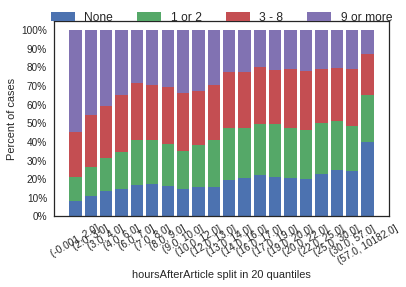

In [65]:
# function to plot the categories across a quantized X variable
def stacked_bar_plotter(x, y='recs', q=20, df=X):
    '''Create a percent-stacked-bars plot of y over the quantized x variable'''
    plt.style.use('seaborn-white')
    df_s = df[[x, y]]
    label = x + ' split in ' + str(q) + ' quantiles'
    df_s[label] = pd.qcut(df[x], q, duplicates='drop')
    # prepare percent categories for each bar
    grouped = df_s.groupby(label).recs.value_counts(normalize=True)
    df_s = grouped.unstack()
    catlabels = ['None', '1 or 2', '3 - 8', '9 or more']
    df_s.columns = catlabels
    df_s['labels'] = df_s.index
    df_s['xticks'] = df_s.labels.cat.codes
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(4):
        bot = df_s.iloc[:, 0:i].sum(axis=1)
        ax.bar(df_s.xticks, df_s.iloc[:, i], bottom=bot)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * .1,
                     box.width, box.height * .9])
    plt.xticks(df_s.xticks, df_s.labels, rotation=30)
    plt.yticks(np.linspace(0, 1, 11),
               [str(x) + '%' for x in range(0, 101, 10)])
    plt.xlabel(label)
    plt.ylabel('Percent of cases')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              labels=catlabels, ncol=4, fontsize='large',
              markerscale=1.5)

stacked_bar_plotter('hoursAfterArticle')

More than half the comments submitted in the first two hours ended up in the highest category with 9 or more upvotes! This is in contrast to less than a quarter for the ones submitted after just 15 hours. Here are the means for the original variable, **recommendations** as well:

In [66]:
# quantile plotter 
def quantile_plotter(x, y='recs', q=20, df=X):
    '''Create a pointplot of y over the quantized x variable'''
    df_small = df[[x, y]]
    label = x + ' split in ' + str(q) + ' quantiles'
    df_small[label] = pd.qcut(df[x], q, duplicates='drop')
    sns.pointplot(x=label,
                  y=y,
                  data=df_small,
                  join=False)
    plt.xticks(rotation=30)
    


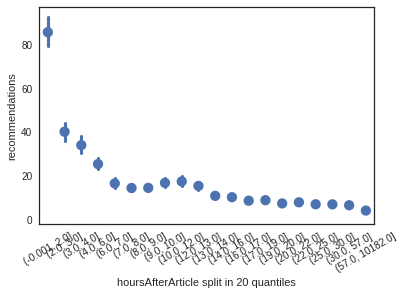

In [67]:
quantile_plotter('hoursAfterArticle', y='recommendations')

It depicts the average number of upvotes (with error bars) per unit of time after the publication of an article. Each unit of time here is based on 5% of the original observations of hours after the article was published before the comment appeared. The trend is clear - the sooner, the better. 
The highest average category (ie highest number of upvotes) happens within the first two hours and then total upvotes gradually decline. There is an uptick around X hours - this is due to the fact that most articles appear online slightly before midnight US Eastern Time, while most people wake up and read articles about 9-11am, so it simply reflects peak readership volume, occuring 9-10 hours later. There is not much point in posting comments roughly two days after the publication of an article.

**Commenting on comments doesn't bring in the upvotes**
The next one is about replying to other users' comments and it also surprised me. Unlike Reddit, where replying to the top comment is often the only way to be noticed, at the Times reply comments rarely attract many upvotes. The feature about replying that we used, **depth** ('1' is original comment, '2' is a response to a comment, '3' is a response to a response and so on) is the strongest predictor of a comment's popularity category. We even tried adding a feature based on the number of upvotes of the original comment, guessing that replying to popular comments should result in more upvotes, but it didn't really make any difference. A simple mean conditional on the level of depth speaks volumes here: original comments have a mean of about 25 upvotes, while level 4 responses are at zero:

In [68]:
X.groupby('depth').recommendations.mean()

depth
1.0    25.883516
2.0     3.008920
3.0     0.675810
4.0     0.142857
5.0     0.000000
Name: recommendations, dtype: float64

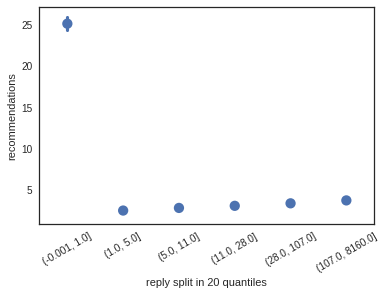

In [69]:
quantile_plotter('reply', 'recommendations')

And a simple linear correlation between the number of upvotes of the original comment and the reply comment shows us there's nothing there (certainly no linear relationship):

In [70]:
X.reply.corr(X.recommendations).round(2)

-0.03

**There is an optimal article length for getting upvoted comments - at about 800 words.** 
Apparently the ideal zone between too short and too long for most readers is somewhere around 800 words. We should keep in mind, though, that this is where most articles are in terms of length anyway. Looking at the plot below, clearly articles below 500 words are just too short. I am surprised there is such a thing as too short an article, but anything less than 500 simply doesn't do it for many readers.

There are several interpretations here. One is that readers who read longer articles tend to be more likely to comment and respond to comments - perhaps they have more time to spend on the site; the 'newspaper junkies'. Another is that articles below 500 words are simply too short to be worthy of much of a response - there isn't all that much to say about them. Finally, it is possible that longer articles simply attract more readers which translates into higher overall upvote counts. I would not have guessed that in general about online articles, but this is the NYTimes, so perhaps the attention span of the average reader is longer than usual. 

Also surprising is the fact that on the opposite end of the spectrum, comments made to articles over 2000 words rake in higher counts on average than anything in between. There is still an audience for the long newspaper article and it does not shy from participating in the communal conversation.

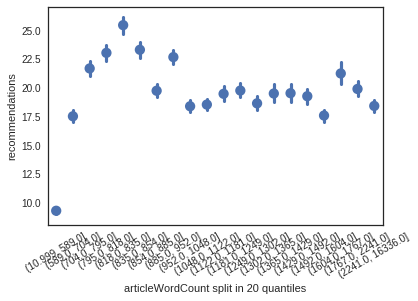

In [71]:
quantile_plotter('articleWordCount', 'recommendations', df=df)

And a jointplot to show the histogram of each along with the joint distribution. The darker the color inside the plot, the more cases that occur there. The outside plots simply show the histogram of each of the variables.  There is a large number of articles at about 700-800 words, which is why we see the spike (dark vertical column) in the hex plot. 

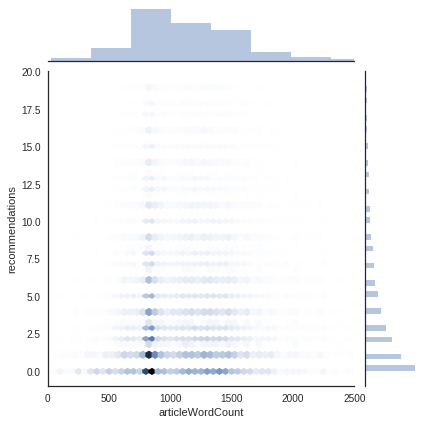

In [72]:
X_plot = X[X.recommendations < 20]
sns.jointplot(x='articleWordCount',
              y='recommendations',
              xlim=(0, 2500),
              ylim=(-1, 20),
              kind="hex",
              data=X_plot,
              extent=[0, 2500, 0, 20],
              stat_func=None)


**Print page - most of the important big-headline articles appear in the first 30 pages of the paper, where they attract more readers and more comments.**

This is why the vast majority of comments are to articles in the first 30 pages. Generally, more important articles appear in the first few pages on the paper version of the newspaper, so naturally we expect upvotes to go down with every page. It is not quite so simple though - the very first few pages including the front page are a mixed bag and there is a peak around pages 19-25 perhaps because of the editorials and columnist sections. 

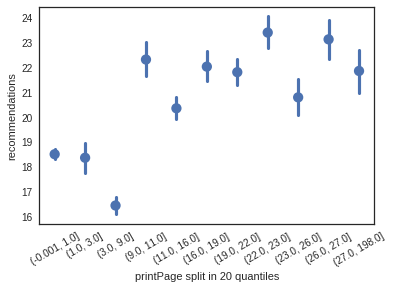

In [73]:
quantile_plotter('printPage', 'recommendations', df=df)

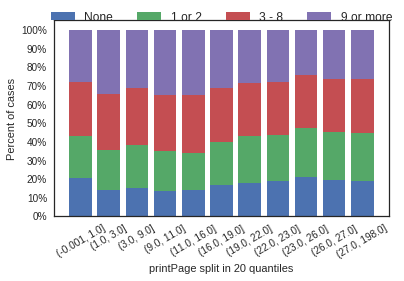

In [74]:
stacked_bar_plotter('printPage', 'recs')

**Getting the coveted 'NYTimes Pick' helps a lot. So does being a trusted user.** 

Again, nothing unusual - the greater visibility that comes with a NYTimes Pick icon and being placed on top of a short list of comments in the NYTimes staff tab obviously results in more comments. Simple comparison of means (even without a t-test which given the sample size would only confirm the obivous) would lead us to conclude that on average getting picked by the staff brings about 250 upvotes!

In [75]:
X.groupby('editorsSelection_1').recommendations.mean()

editorsSelection_1
0     14.282758
1    301.788889
Name: recommendations, dtype: float64

In [76]:
X.groupby('trusted').recommendations.mean()


trusted
0.0    17.691285
1.0    75.878780
Name: recommendations, dtype: float64

**Hot button issues bring about reactions, but not always upvotes** 
                                
Articles about things like 'school shootings', 'global warming', 'russia', are consistently associated with comments that receive _fewer_ upvotes on average. This could be simply because too many people react by writing comments, but I don't think it is that simple. It might be something about the emotional reaction the articles evoke or about a selection effect - who reads them and whether they tend to upvote. Intriguingly some article keywords and even comment words (words included in a comment) are associated with higher upvotes - for example: 'women' and 'illegal immigration.' This might also reflect the period of time the articles covered and might be, in some sense, over-fitting to one or a few articles, but more probing would be necessary to make sense of these features. 

Keyword:"global warming"
0    19.799027
1    16.575217
Name: recommendations, dtype: float64


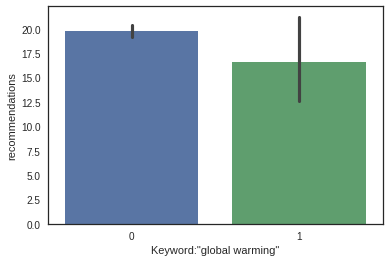

In [77]:
print(X.groupby('Keyword:"global warming"').recommendations.mean())
sns.barplot(x='Keyword:"global warming"',
            y='recommendations',
            data=X)



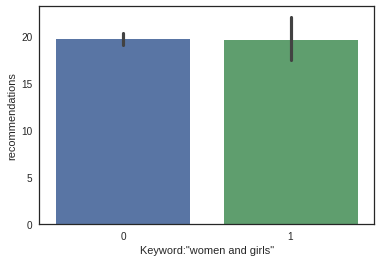

In [78]:
sns.barplot(x='Keyword:"women and girls"',
            y='recommendations',
            data=X)


**Effort pays off: say more; use a rich vocabulary; refer to people, places and organizations sparingly; spell-check!**
I was really curious whether comment length, or the use of sophisticated vocabulary (measured by IDF and word length), grammar complexity (max sentence length), spelling error rates, or the use of particular parts of speech more often leads to higher upvote counts. The classification model provides some evidence that all of these things matter. Starting with the easiest one, here is a look at comment word length:


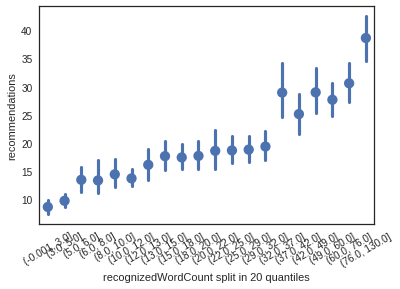

In [79]:
quantile_plotter('recognizedWordCount', 'recommendations')

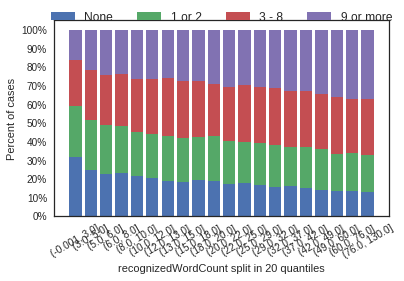

In [80]:
stacked_bar_plotter('recognizedWordCount', 'recs')

The relationship between comment size and upvotes is almost monotonic - and the highest length of over 77 words displays the highest average upvote totals.

Next, let's look at one of the features that reflect vocabulary sophistication - the average inverse document frequency for a comment. There seems to be an ideal range in the middle here, but I am affraid it might be influenced by the presense of overly short comments - that's a sure way of getting very low or very high average IDF.

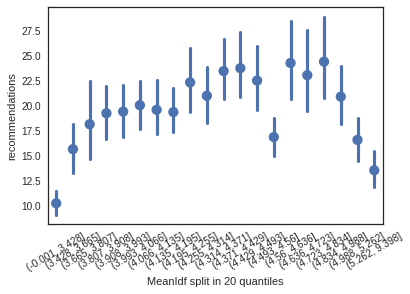

In [81]:
quantile_plotter('MeanIdf', 'recommendations')

If we limit the comments to only those longer than 10 words, the range does shrink, so size was a confounding factor here. The only thing we can conclude from the plot is that low IDF does bring a comment down, but a higher average infrequency of words does not really help.

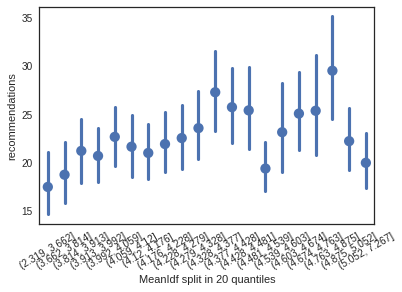

In [82]:
quantile_plotter('MeanIdf', 'recommendations', df=X.loc[X.recognizedWordCount > 10, :])

The other measure of vocabulary complexity that showed up in the top features of the model is very simple - average word length. It behaves in much the same way - too low is a problem, but beyond a certain threshold, it makes little difference.

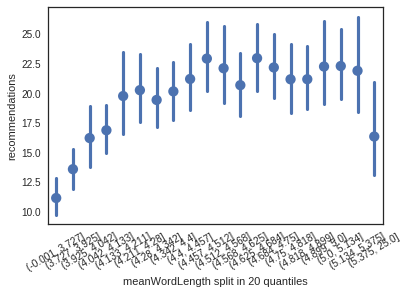

In [83]:
quantile_plotter('meanWordLength', 'recommendations')

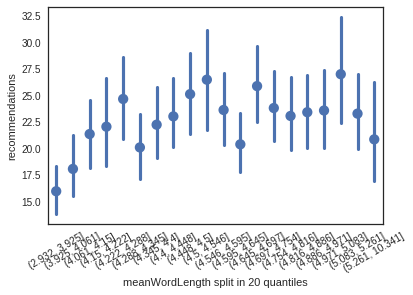

In [84]:
quantile_plotter('meanWordLength', 'recommendations', df=X.loc[X.recognizedWordCount > 10, :])

Let's finish the IDF measures with max. The idea is that if a comment contains one very rare word, it is more likely to get upvotes. Yep, that does seem to be true and ditto for max word length and even our measure of grammar complexity (very crude) - max sentence length:

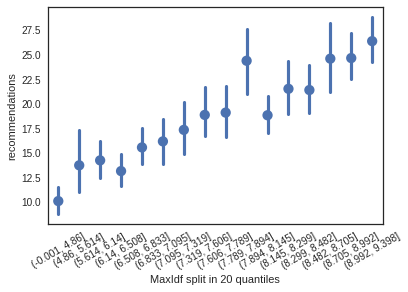

In [85]:
quantile_plotter('MaxIdf', 'recommendations')

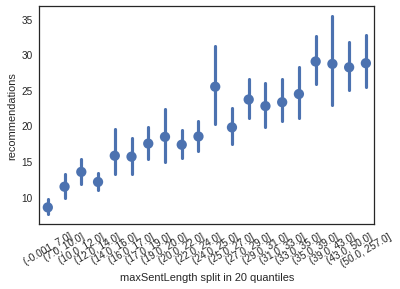

In [86]:
quantile_plotter('maxSentLength', 'recommendations')

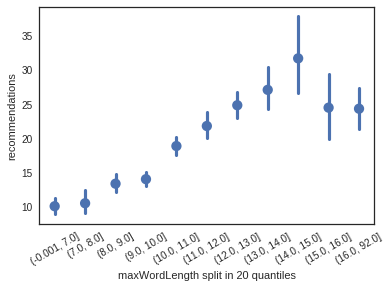

In [87]:
quantile_plotter('maxWordLength', 'recommendations')

Spelling next: generally the higher the number of spelling mistakes, the lower the upvote count. The number of comments with no spelling erorrs is very high, which is why the value at zero is both lower and has a much smaller error bar. 

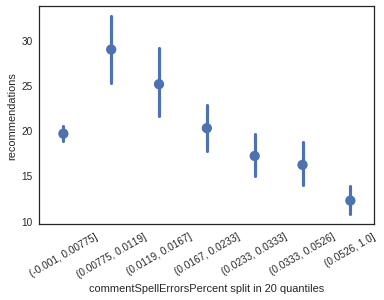

In [88]:
quantile_plotter('commentSpellErrorsPercent', 'recommendations')

Finally, among the parts-of-speech tags there is a notable leader - 'NNP,' which stands for names of people, organizations or places (proper nouns). Too many names or too few leads to lower upvote totals. Naturally, this could be a function of the types of articles that include many names - politics & news. It is not due to very short comments, however.

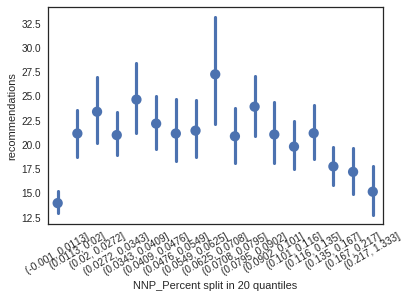

In [89]:
quantile_plotter('NNP_Percent', 'recommendations')

**Don't be too negative or too positive, be slightly positive.**
                                
Finally, let's look at the tone of the comments - polarity measures positive or negative affect, essentially what is the ratio of negative to positive words, on a scale from -1 to 1. It seems that overly critical or overly effusive sounding comments don't fare well with the audience - there is an optimum close to neutrality, erring slightly on the side of positive. The dip at zero is simply due to the large number of cases there.

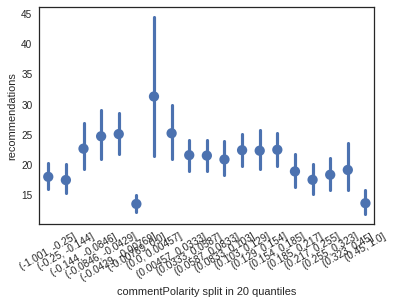

In [90]:
quantile_plotter('commentPolarity', 'recommendations')

OK, one last question: does the time of day and day of the week matter and if so how? Some of the dummies based on these features appear to give the gradient boost sizeable gain.

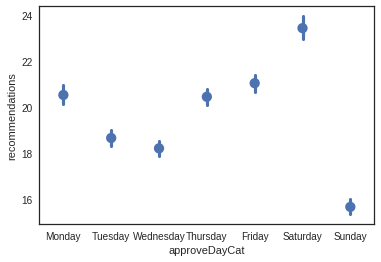

In [91]:
categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['approveDayCat'] = df.approveDay.astype('category',
                                           ordered=True,
                                           categories=categories)
sns.pointplot(x = 'approveDayCat',
              y = 'recommendations',
              data=df,
              join=False
)

Hmm, I didn't expect this - apparently there is a build-up in terms of comments (and probably reading of articles) from Thursday to Saturday; Sunday is the worst day to comment and then the first three work days see a gradual descent to the weekly nadir on Wednesday. The differences between the days of the week are not large, but it is rather intriguing that they exist.

Finally, these are the hours of the day at which comments get the highest upvote counts: clear spike around 9AM, while most comments are posted in the early afternoon. Does this mean that the early bird gets the upvote worm or is simply a function of NYTimes reporters commenting in those hours?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

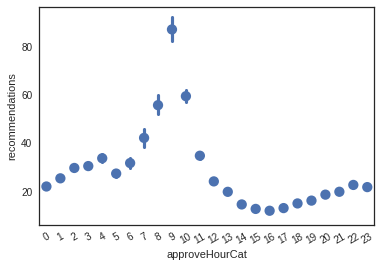

In [92]:
df['approveHourCat'] = df.approveTime.dt.hour
sns.pointplot(x = 'approveHourCat',
              y = 'recommendations',
              data=df,
              join=False)
                                
plt.xticks(rotation=30)

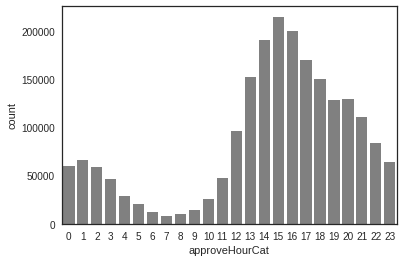

In [93]:
sns.countplot('approveHourCat', data=df, color='gray')

### This is all, hope you enjoyed it :)

